### Script to plot maps using TC-tracked mask

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
import subprocess
from mask_tc_track import mask_tc_track
from azim_wind_latlon import azim_wind_latlon
from thermo_functions import relh#density_moist, theta_equiv, theta_virtual, 

#### Main Settings

In [2]:
# #### Time selection

# nd = 3 # ndays
nt = 1#nd*24

# This has been tested for corresponding time steps:
#   t0=37,1 are the first divergent time steps in CTL,NCRF
#   t0=25,1 are the first divergent time steps in NCRF,CRFON
t0=36
t0+=1 # add one time step since NCRF(t=0) = CTL
t1 = t0+nt

# Pressure level to plot
pres_plot = 500

# #### Directories

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
figdir = "/home/jamesrup/figures/tc/ens/haiyan/"

storm='haiyan'
memb='memb_01'
test='ctl'

datdir2 = 'post/d02/'
# datdir2 = 'post/d02/v2/'
datdir = main+storm+'/'+memb+'/'+test+'/'+datdir2
# datdir+='v2/'

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (km) limit to keep unmasked

track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
# track_file = datdir+'../../../track_'+var_track+'_'+ptrack+'hPa.nc'

In [3]:
ncfile = Dataset(track_file)
clon = ncfile.variables['clon'][:] # deg
clat = ncfile.variables['clat'][:] # deg
ncfile.close()

In [4]:
##### Get dimensions
process = subprocess.Popen(['ls '+datdir+'../../wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

varfil_main = Dataset(datdir+'T.nc')
pres = varfil_main.variables['pres'][:] # hPa
varfil_main.close()


In [5]:
ikread = np.where(pres == pres_plot)[0][0]

In [6]:
def var_read_3d(datdir,varname,t0,t1,ik):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,ik,:,:]
    var = var[:,np.newaxis,:,:]
    varfil_main.close()
    return var
def var_read_2d(datdir,varname,t0,t1):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][t0:t1,:,:,:]
    varfil_main.close()
    return var

In [7]:
# Read 10m winds
# varname = 'U10'
# u = var_read_2d(datdir,varname,t0,t1)
# varname = 'V10'
# v = var_read_2d(datdir,varname,t0,t1)

varname = 'U'
u = var_read_3d(datdir,varname,t0,t1,ikread)
varname = 'V'
v = var_read_3d(datdir,varname,t0,t1,ikread)

varname = 'QVAPOR'
qv = var_read_3d(datdir,varname,t0,t1,ikread) # kg/kg
varname = 'T'
tmpk = var_read_3d(datdir,varname,t0,t1,ikread) # K
var = relh(qv,pres[np.newaxis,:,np.newaxis,np.newaxis]*1e2,tmpk,ice=1) # %

In [8]:
# # Calculate tangential wind
# vtan = azim_wind_latlon(track_file, u, v, lon, lat, t0, t1)
# # Mask out beyond radius
# vtan = mask_tc_track(track_file, rmax, vtan, lon, lat, t0, t1)

In [9]:
# Mask out beyond radius
var = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)

---
### Plotting routines

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

##### Plot masked variable radius map

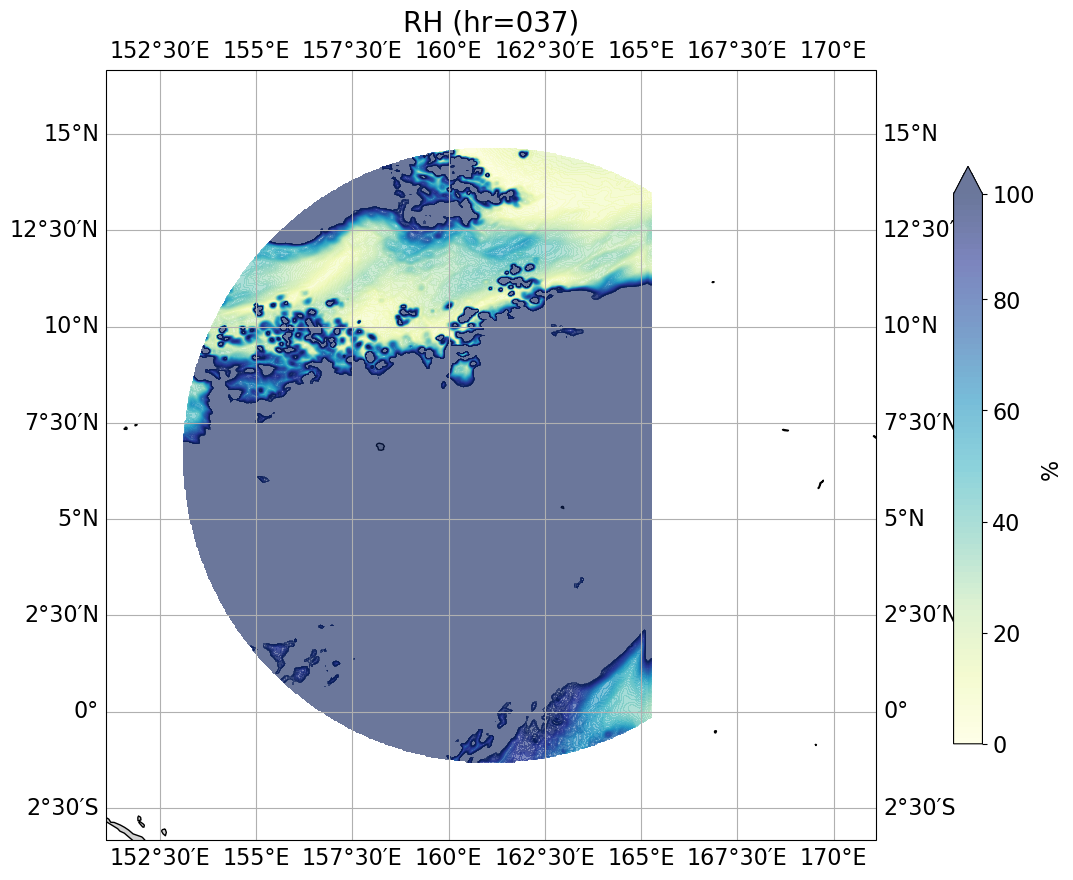

In [11]:
# select plotting area
plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N

# tsel=36
# for tsel in range(5,nt,6):
# for tsel in range(50,51):
    
hr_tag = str(np.char.zfill(str(t0), 3))

# Wind
# iu = u[tsel,:,:]
# iv = v[tsel,:,:]
# pltvar=vtan[tsel,0,:,:]
vartag='$v_{tan}$'
unittag='m/s'
# clevs = np.arange(-50,50)
clevs = np.arange(0,25)

# Relative humidity
pltvar=var[0,0,:,:]
vartag='RH'
unittag='%'
clevs = np.arange(0,100)

# create figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(vartag+' (hr='+hr_tag+')', fontsize=20)

# fill contour
im = ax.contourf(lon, lat, pltvar, clevs, cmap='YlGnBu', alpha=0.6,
                    extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel(unittag)

# # storm track
# plt.plot(clon, clat, color="black", linewidth=2)
# plt.plot(clon, clat, "s", color="black")
# # current time
# plt.plot(clon[t0+tsel], clat[t0+tsel], "s", color="blue", markersize=15)
# # all-time max (time step 168)
# # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_area)
tc_locx=clon[t0]
tc_locy=clat[t0]
rad_plt=10
plt_tcloc=[tc_locx-rad_plt, tc_locx+rad_plt, tc_locy-rad_plt, tc_locy+rad_plt] # W,E,S,N
ax.set_extent(plt_tcloc)

plt.show()
# plt.close()